In [2]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 1 : Imports et Configuration
# ════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports OK")

✅ Imports OK


In [3]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 2 : Chargement des Données
# ════════════════════════════════════════════════════════════════════

# Charger les recommandations finales
recommendations = pd.read_csv('../data/processed/final_recommendations.csv')

# Filtrer les hôtels avec coordonnées GPS
hotels_with_gps = recommendations[
    recommendations['latitude'].notna() & 
    recommendations['longitude'].notna()
].copy()

print("📊 DONNÉES CHARGÉES\n")
print(f"Total recommandations : {len(recommendations)}")
print(f"Avec coordonnées GPS : {len(hotels_with_gps)} ({len(hotels_with_gps)/len(recommendations)*100:.1f}%)")
print(f"Villes : {recommendations['city'].nunique()}")

print("\n🏆 Top 5 hôtels :")
print(recommendations.head(5)[['rank', 'city', 'hotel_name', 'final_score', 'price']])

📊 DONNÉES CHARGÉES

Total recommandations : 75
Avec coordonnées GPS : 75 (100.0%)
Villes : 5

🏆 Top 5 hôtels :
   rank                city  \
0     1     Aix en Provence   
1     2  Bormes les Mimosas   
2     3     Aix en Provence   
3     4  Bormes les Mimosas   
4     5  Bormes les Mimosas   

                                          hotel_name  final_score  price  
0                                   La Villa Rustica     9.863708  234.0  
1  Le Mas de la Palmeraie - Studio dans propriété...     9.567594  198.0  
2                          Les Suites du Cours & Spa     9.445540  398.0  
3                      La Favière proche de la plage     9.439474  242.0  
4                                Boulevard du Soleil     9.439474  242.0  


In [ ]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 3 : Carte Interactive - Tous les Hôtels
# ════════════════════════════════════════════════════════════════════

print("\n🗺️ CRÉATION DE LA CARTE INTERACTIVE\n")
print("="*60)

# Centre de la carte (centre de la région PACA)
center_lat = hotels_with_gps['latitude'].mean()
center_lon = hotels_with_gps['longitude'].mean()

# Créer la carte
map_all = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Définir les couleurs selon le score final
def get_color(score):
    """Retourne une couleur selon le score."""
    if score >= 8:
        return 'darkgreen'
    elif score >= 7:
        return 'green'
    elif score >= 6:
        return 'lightgreen'
    elif score >= 5:
        return 'orange'
    else:
        return 'red'


# Ajouter les marqueurs pour chaque hôtel
for idx, hotel in hotels_with_gps.iterrows():
    # Popup avec informations détaillées
    popup_html = f"""
    <div style="width: 300px; font-family: Arial;">
        <h4 style="margin-bottom: 10px; color: #2c3e50;">{hotel['hotel_name']}</h4>
        <hr style="margin: 5px 0;">
        <p><b>📍 Ville :</b> {hotel['city']}</p>
        <p><b>⭐ Note :</b> {hotel['score']:.1f}/10 ({hotel['number_of_reviews']:.0f} avis)</p>
        <p><b>💰 Prix :</b> {hotel['price']:.0f} {hotel['currency']}/nuit</p>
        <p><b>🌤️ Score météo :</b> {hotel['avg_weather_score']:.2f}</p>
        <p><b>🎯 Score final :</b> <span style="color: {get_color(hotel['final_score'])}; font-weight: bold;">{hotel['final_score']:.2f}/10</span></p>
        <p><b>🏆 Rang :</b> #{hotel['rank']:.0f}</p>
        <hr style="margin: 5px 0;">
        <p style="font-size: 11px;"><a href="{hotel['url']}" target="_blank">🔗 Voir sur Booking.com</a></p>
    </div>
    """
    
    # Icône selon le score
    icon_color = get_color(hotel['final_score'])
    
    folium.Marker(
        location=[hotel['latitude'], hotel['longitude']],
        popup=folium.Popup(popup_html, max_width=300),
        tooltip=f"{hotel['hotel_name']} - Score: {hotel['final_score']:.2f}",
        icon=folium.Icon(color=icon_color, icon='home', prefix='fa')
    ).add_to(map_all)

# Ajouter une légende
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 200px; height: 180px; 
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius: 5px; padding: 10px">
     <p style="margin-top:0; font-weight:bold;">Score Final</p>
     <p><i class="fa fa-map-marker" style="color:darkgreen"></i> ≥ 8.0 : Excellent</p>
     <p><i class="fa fa-map-marker" style="color:green"></i> 7.0-7.9 : Très bien</p>
     <p><i class="fa fa-map-marker" style="color:lightgreen"></i> 6.0-6.9 : Bien</p>
     <p><i class="fa fa-map-marker" style="color:orange"></i> 5.0-5.9 : Moyen</p>
     <p><i class="fa fa-map-marker" style="color:red"></i> < 5.0 : Faible</p>
</div>
'''
map_all.get_root().html.add_child(folium.Element(legend_html))

# Sauvegarder
map_all.save('../data/processed/carte_tous_hotels.html')
print("✅ Carte créée : data/processed/carte_tous_hotels.html")
print(f"   📍 {len(hotels_with_gps)} hôtels localisés")


🗺️ CRÉATION DE LA CARTE INTERACTIVE

✅ Carte créée : data/processed/carte_tous_hotels.html
   📍 75 hôtels localisés


In [6]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 4 : Carte Interactive - Top 20
# ════════════════════════════════════════════════════════════════════

print("\n🏆 CARTE DES TOP 20\n")
print("="*60)

# Top 20 avec GPS
top20_with_gps = recommendations.head(20)
top20_with_gps = top20_with_gps[
    top20_with_gps['latitude'].notna() & 
    top20_with_gps['longitude'].notna()
]

# Créer la carte
map_top20 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='CartoDB positron'
)

# Ajouter les marqueurs avec numéros
for idx, hotel in top20_with_gps.iterrows():
    popup_html = f"""
    <div style="width: 300px; font-family: Arial;">
        <h3 style="color: #e74c3c; margin-bottom: 5px;">🏆 Rang #{hotel['rank']:.0f}</h3>
        <h4 style="margin: 5px 0; color: #2c3e50;">{hotel['hotel_name']}</h4>
        <hr style="margin: 5px 0;">
        <p><b>📍</b> {hotel['city']}</p>
        <p><b>⭐</b> {hotel['score']:.1f}/10 ({hotel['number_of_reviews']:.0f} avis)</p>
        <p><b>💰</b> {hotel['price']:.0f} {hotel['currency']}</p>
        <p><b>🌤️</b> Score météo: {hotel['avg_weather_score']:.2f}</p>
        <p><b>🌡️</b> {hotel['temp_avg']:.1f}°C</p>
        <p><b>🎯</b> <span style="font-size: 16px; color: #27ae60; font-weight: bold;">Score: {hotel['final_score']:.2f}/10</span></p>
        <hr style="margin: 5px 0;">
        <p style="font-size: 11px;"><a href="{hotel['url']}" target="_blank">🔗 Réserver sur Booking.com</a></p>
    </div>
    """
    
    # Marqueur numéroté
    folium.Marker(
        location=[hotel['latitude'], hotel['longitude']],
        popup=folium.Popup(popup_html, max_width=320),
        tooltip=f"#{hotel['rank']:.0f} - {hotel['hotel_name']}",
        icon=folium.DivIcon(html=f"""
            <div style="
                background-color: #e74c3c;
                color: white;
                border-radius: 50%;
                width: 30px;
                height: 30px;
                display: flex;
                align-items: center;
                justify-content: center;
                font-weight: bold;
                font-size: 14px;
                border: 2px solid white;
                box-shadow: 0 2px 5px rgba(0,0,0,0.3);
            ">{int(hotel['rank'])}</div>
        """)
    ).add_to(map_top20)

map_top20.save('../data/processed/carte_top20.html')
print(f"✅ Carte Top 20 créée : data/processed/carte_top20.html")
print(f"   🏆 {len(top20_with_gps)} hôtels d'élite")


🏆 CARTE DES TOP 20

✅ Carte Top 20 créée : data/processed/carte_top20.html
   🏆 20 hôtels d'élite



📊 CRÉATION DES GRAPHIQUES AVANCÉS

✅ Dashboard sauvegardé : data/processed/dashboard_complet.png


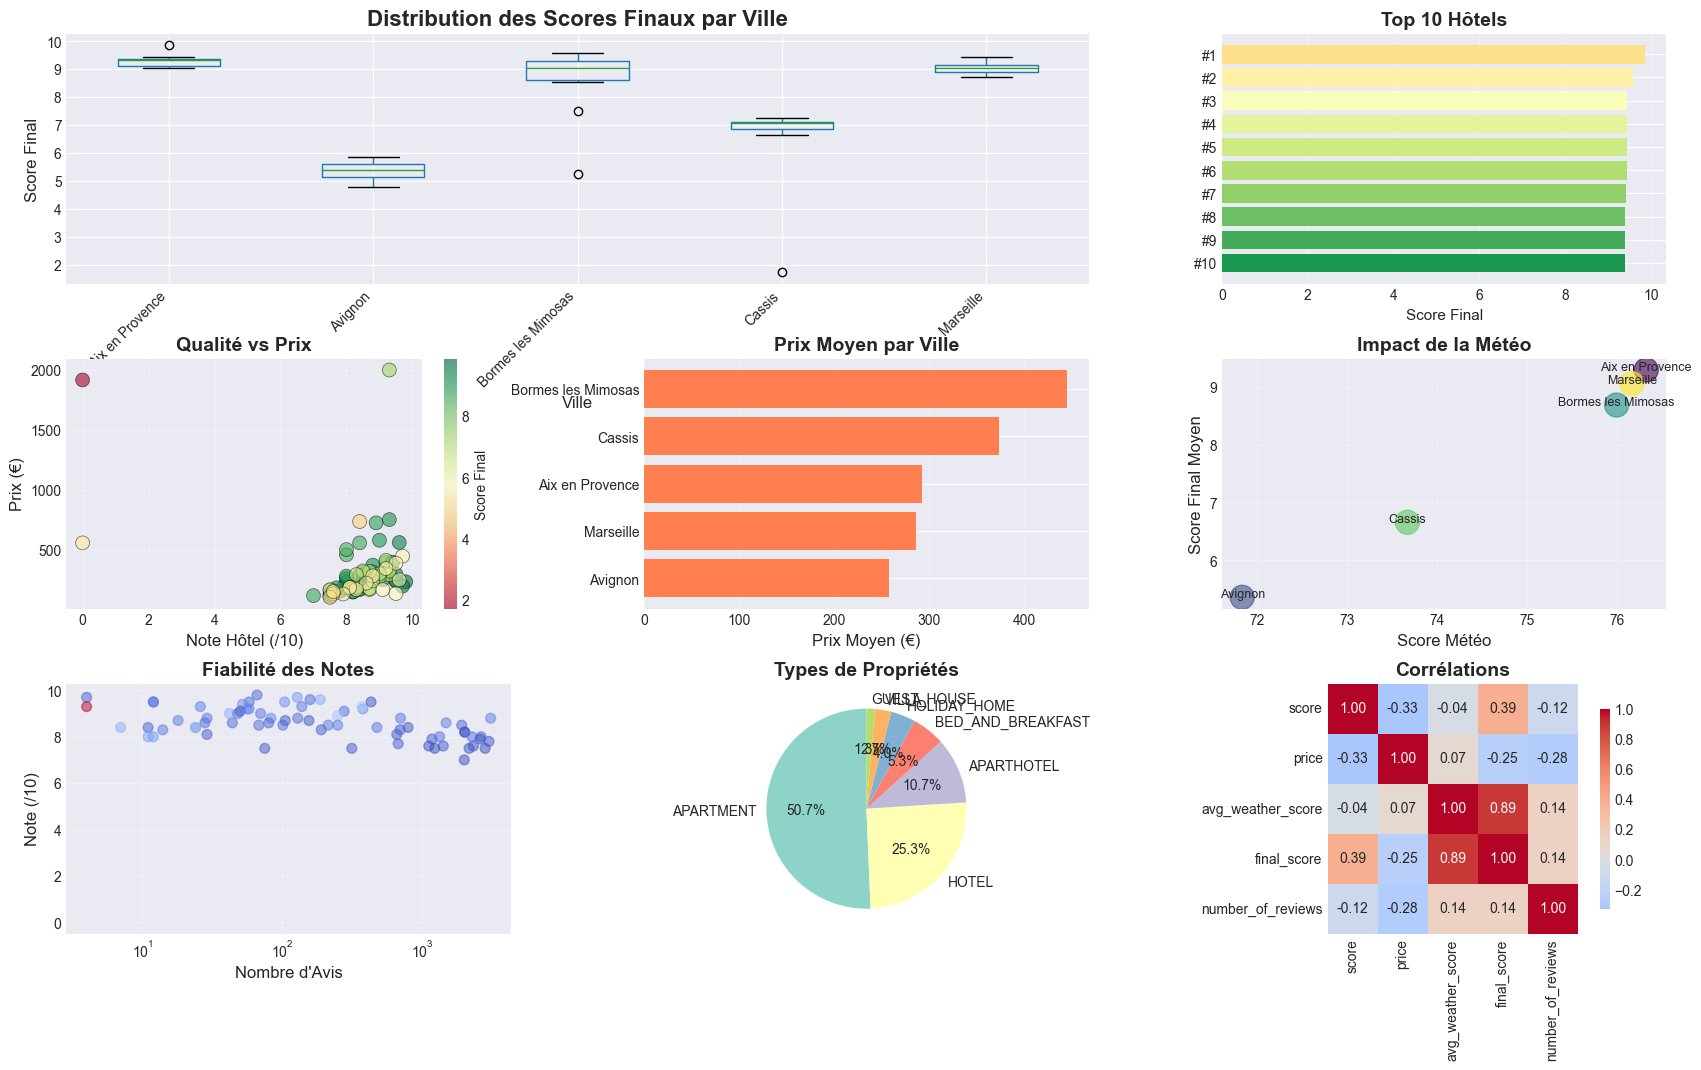

In [7]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 5 : Graphiques Avancés
# ════════════════════════════════════════════════════════════════════

print("\n📊 CRÉATION DES GRAPHIQUES AVANCÉS\n")
print("="*60)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribution des scores finaux par ville
ax1 = fig.add_subplot(gs[0, :2])
recommendations.boxplot(column='final_score', by='city', ax=ax1)
ax1.set_title('Distribution des Scores Finaux par Ville', fontsize=16, fontweight='bold')
ax1.set_xlabel('Ville', fontsize=12)
ax1.set_ylabel('Score Final', fontsize=12)
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')
plt.suptitle('')  # Supprimer le titre automatique

# 2. Top 10 hôtels
ax2 = fig.add_subplot(gs[0, 2])
top10 = recommendations.head(10)
colors = plt.cm.RdYlGn(np.linspace(0.4, 0.9, 10))
ax2.barh(range(10), top10['final_score'], color=colors)
ax2.set_yticks(range(10))
ax2.set_yticklabels([f"#{i+1}" for i in range(10)])
ax2.set_xlabel('Score Final', fontsize=11)
ax2.set_title('Top 10 Hôtels', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Relation Score vs Prix
ax3 = fig.add_subplot(gs[1, 0])
scatter = ax3.scatter(recommendations['score'], recommendations['price'], 
                     c=recommendations['final_score'], cmap='RdYlGn',
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Note Hôtel (/10)', fontsize=12)
ax3.set_ylabel('Prix (€)', fontsize=12)
ax3.set_title('Qualité vs Prix', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='Score Final')
ax3.grid(True, alpha=0.3)

# 4. Distribution des prix par ville
ax4 = fig.add_subplot(gs[1, 1])
city_prices = recommendations.groupby('city')['price'].mean().sort_values()
ax4.barh(city_prices.index, city_prices.values, color='coral')
ax4.set_xlabel('Prix Moyen (€)', fontsize=12)
ax4.set_title('Prix Moyen par Ville', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Météo vs Score Final
ax5 = fig.add_subplot(gs[1, 2])
city_data = recommendations.groupby('city').agg({
    'avg_weather_score': 'first',
    'final_score': 'mean'
}).reset_index()
ax5.scatter(city_data['avg_weather_score'], city_data['final_score'], 
           s=300, alpha=0.6, c=range(len(city_data)), cmap='viridis')
for idx, row in city_data.iterrows():
    ax5.annotate(row['city'], (row['avg_weather_score'], row['final_score']),
                fontsize=9, ha='center')
ax5.set_xlabel('Score Météo', fontsize=12)
ax5.set_ylabel('Score Final Moyen', fontsize=12)
ax5.set_title('Impact de la Météo', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Nombre d'avis vs Note
ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(recommendations['number_of_reviews'], recommendations['score'],
           alpha=0.5, c=recommendations['price'], cmap='coolwarm', s=50)
ax6.set_xlabel('Nombre d\'Avis', fontsize=12)
ax6.set_ylabel('Note (/10)', fontsize=12)
ax6.set_title('Fiabilité des Notes', fontsize=14, fontweight='bold')
ax6.set_xscale('log')
ax6.grid(True, alpha=0.3)

# 7. Répartition par type de propriété
ax7 = fig.add_subplot(gs[2, 1])
property_counts = recommendations['property_type'].value_counts().head(8)
ax7.pie(property_counts.values, labels=property_counts.index, autopct='%1.1f%%',
       startangle=90, colors=plt.cm.Set3.colors)
ax7.set_title('Types de Propriétés', fontsize=14, fontweight='bold')

# 8. Heatmap des corrélations
ax8 = fig.add_subplot(gs[2, 2])
corr_data = recommendations[['score', 'price', 'avg_weather_score', 
                             'final_score', 'number_of_reviews']].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', 
           center=0, square=True, ax=ax8, cbar_kws={'shrink': 0.8})
ax8.set_title('Corrélations', fontsize=14, fontweight='bold')

plt.savefig('../data/processed/dashboard_complet.png', dpi=300, bbox_inches='tight')
print("✅ Dashboard sauvegardé : data/processed/dashboard_complet.png")
plt.show()

In [8]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 6 : Rapport HTML Interactif
# ════════════════════════════════════════════════════════════════════

print("\n📄 GÉNÉRATION DU RAPPORT HTML\n")
print("="*60)

# Statistiques
total_hotels = len(recommendations)
cities = recommendations['city'].nunique()
avg_score = recommendations['final_score'].mean()
avg_price = recommendations['price'].mean()
best_city_weather = recommendations.groupby('city')['avg_weather_score'].first().idxmax()
best_value = recommendations.nsmallest(1, 'price').iloc[0]

# Top 5
top5 = recommendations.head(5)

# HTML
html_content = f"""
<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Rapport Kayak - Destinations PACA</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
        }}
        
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            background: white;
            border-radius: 20px;
            box-shadow: 0 20px 60px rgba(0,0,0,0.3);
            overflow: hidden;
        }}
        
        header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }}
        
        header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
        }}
        
        header p {{
            font-size: 1.2em;
            opacity: 0.9;
        }}
        
        .stats {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            padding: 40px;
            background: #f8f9fa;
        }}
        
        .stat-card {{
            background: white;
            padding: 25px;
            border-radius: 15px;
            text-align: center;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            transition: transform 0.3s;
        }}
        
        .stat-card:hover {{
            transform: translateY(-5px);
            box-shadow: 0 8px 12px rgba(0,0,0,0.15);
        }}
        
        .stat-card .number {{
            font-size: 2.5em;
            font-weight: bold;
            color: #667eea;
            margin: 10px 0;
        }}
        
        .stat-card .label {{
            color: #666;
            font-size: 0.9em;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}
        
        .section {{
            padding: 40px;
        }}
        
        .section h2 {{
            font-size: 2em;
            margin-bottom: 30px;
            color: #667eea;
            border-bottom: 3px solid #667eea;
            padding-bottom: 10px;
        }}
        
        .hotel-card {{
            background: #f8f9fa;
            border-radius: 15px;
            padding: 25px;
            margin-bottom: 20px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            transition: all 0.3s;
            border-left: 5px solid #667eea;
        }}
        
        .hotel-card:hover {{
            box-shadow: 0 8px 16px rgba(0,0,0,0.2);
            transform: translateX(5px);
        }}
        
        .hotel-card h3 {{
            color: #333;
            margin-bottom: 15px;
            font-size: 1.4em;
        }}
        
        .hotel-info {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(150px, 1fr));
            gap: 15px;
            margin-top: 15px;
        }}
        
        .info-item {{
            display: flex;
            align-items: center;
            gap: 8px;
        }}
        
        .badge {{
            display: inline-block;
            padding: 5px 12px;
            border-radius: 20px;
            font-size: 0.85em;
            font-weight: bold;
        }}
        
        .badge-rank {{
            background: #e74c3c;
            color: white;
        }}
        
        .badge-score {{
            background: #27ae60;
            color: white;
        }}
        
        .badge-price {{
            background: #f39c12;
            color: white;
        }}
        
        .maps {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin-top: 20px;
        }}
        
        .map-container {{
            border-radius: 15px;
            overflow: hidden;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }}
        
        iframe {{
            width: 100%;
            height: 500px;
            border: none;
        }}
        
        footer {{
            background: #2c3e50;
            color: white;
            text-align: center;
            padding: 30px;
        }}
        
        @media (max-width: 768px) {{
            .maps {{
                grid-template-columns: 1fr;
            }}
            
            header h1 {{
                font-size: 1.8em;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>🏖️ Rapport Kayak - Destinations PACA</h1>
            <p>Analyse complète des meilleures destinations et hébergements</p>
        </header>
        
        <div class="stats">
            <div class="stat-card">
                <div class="label">🏨 Hôtels Analysés</div>
                <div class="number">{total_hotels}</div>
            </div>
            <div class="stat-card">
                <div class="label">🌍 Villes</div>
                <div class="number">{cities}</div>
            </div>
            <div class="stat-card">
                <div class="label">⭐ Score Moyen</div>
                <div class="number">{avg_score:.2f}/10</div>
            </div>
            <div class="stat-card">
                <div class="label">💰 Prix Moyen</div>
                <div class="number">{avg_price:.0f}€</div>
            </div>
            <div class="stat-card">
                <div class="label">☀️ Meilleure Météo</div>
                <div class="number">{best_city_weather}</div>
            </div>
        </div>
        
        <div class="section">
            <h2>🏆 Top 5 Recommandations</h2>
"""

for idx, hotel in top5.iterrows():
    html_content += f"""
            <div class="hotel-card">
                <span class="badge badge-rank">#{int(hotel['rank'])}</span>
                <h3>{hotel['hotel_name']}</h3>
                <div class="hotel-info">
                    <div class="info-item">
                        <span>📍</span>
                        <span><strong>{hotel['city']}</strong></span>
                    </div>
                    <div class="info-item">
                        <span>⭐</span>
                        <span>{hotel['score']:.1f}/10 ({int(hotel['number_of_reviews'])} avis)</span>
                    </div>
                    <div class="info-item">
                        <span>💰</span>
                        <span>{hotel['price']:.0f} {hotel['currency']}/nuit</span>
                    </div>
                    <div class="info-item">
                        <span>🌤️</span>
                        <span>Météo: {hotel['avg_weather_score']:.2f}</span>
                    </div>
                    <div class="info-item">
                        <span>🎯</span>
                        <span class="badge badge-score">Score: {hotel['final_score']:.2f}/10</span>
                    </div>
                </div>
                <p style="margin-top: 15px;">
                    <a href="{hotel['url']}" target="_blank" style="color: #667eea; text-decoration: none; font-weight: bold;">
                        🔗 Voir sur Booking.com →
                    </a>
                </p>
            </div>
"""

html_content += f"""
        </div>
        
        <div class="section">
            <h2>🗺️ Cartes Interactives</h2>
            <div class="maps">
                <div class="map-container">
                    <h3 style="text-align: center; padding: 15px; background: #f8f9fa;">
                        Tous les Hôtels ({len(hotels_with_gps)})
                    </h3>
                    <iframe src="carte_tous_hotels.html"></iframe>
                </div>
                <div class="map-container">
                    <h3 style="text-align: center; padding: 15px; background: #f8f9fa;">
                        Top 20 Recommandations
                    </h3>
                    <iframe src="carte_top20.html"></iframe>
                </div>
            </div>
        </div>
        
        <div class="section">
            <h2>📊 Analyse Visuelle</h2>
            <img src="dashboard_complet.png" alt="Dashboard" style="width: 100%; border-radius: 15px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        </div>
        
        <footer>
            <p>Rapport généré le {pd.Timestamp.now().strftime('%d/%m/%Y à %H:%M')}</p>
            <p>Projet Kayak - Analyse Data Science</p>
        </footer>
    </div>
</body>
</html>
"""

# Sauvegarder
with open('../data/processed/rapport_final.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("✅ Rapport HTML créé : data/processed/rapport_final.html")


📄 GÉNÉRATION DU RAPPORT HTML

✅ Rapport HTML créé : data/processed/rapport_final.html


In [9]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 7 : Résumé Final
# ════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("🎉 RAPPORT FINAL TERMINÉ")
print("="*80)

print("\n📂 Fichiers générés :")
print("   ✅ data/processed/carte_tous_hotels.html")
print("   ✅ data/processed/carte_top20.html")
print("   ✅ data/processed/dashboard_complet.png")
print("   ✅ data/processed/rapport_final.html")

print("\n📊 Statistiques :")
print(f"   • {total_hotels} hôtels analysés")
print(f"   • {cities} villes")
print(f"   • {len(hotels_with_gps)} hôtels géolocalisés")
print(f"   • Score moyen : {avg_score:.2f}/10")
print(f"   • Prix moyen : {avg_price:.0f}€")

print("\n🏆 Meilleurs choix :")
print(f"   • Meilleure météo : {best_city_weather}")
print(f"   • Meilleur rapport qualité/prix : {best_value['hotel_name']}")
print(f"   • Top 1 global : {top5.iloc[0]['hotel_name']} ({top5.iloc[0]['city']})")

print("\n🌐 Pour voir le rapport complet :")
print("   👉 Ouvrez : data/processed/rapport_final.html")

print("\n" + "="*80)
print("✅ ÉTAPE 3.4 TERMINÉE - Projet Kayak complet !")
print("="*80)


🎉 RAPPORT FINAL TERMINÉ

📂 Fichiers générés :
   ✅ data/processed/carte_tous_hotels.html
   ✅ data/processed/carte_top20.html
   ✅ data/processed/dashboard_complet.png
   ✅ data/processed/rapport_final.html

📊 Statistiques :
   • 75 hôtels analysés
   • 5 villes
   • 75 hôtels géolocalisés
   • Score moyen : 7.80/10
   • Prix moyen : 329€

🏆 Meilleurs choix :
   • Meilleure météo : Aix en Provence
   • Meilleur rapport qualité/prix : Hôtel Les Corps Saints
   • Top 1 global : La Villa Rustica (Aix en Provence)

🌐 Pour voir le rapport complet :
   👉 Ouvrez : data/processed/rapport_final.html

✅ ÉTAPE 3.4 TERMINÉE - Projet Kayak complet !
